In [3]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [4]:
class DataGenerator:
    def __init__(
        self,
        target_normal_params = {'loc': 0, 'scale': 1},
        treatment_effect: float = 0.0,
        decay_factor: float = 1.0,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.target_normal_params = target_normal_params
        self.treatment_effect = treatment_effect
        self.decay_factor = decay_factor
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-decay_factor*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        full_panel_data = np.clip(np.random.normal(size=(n_samples, self.total_panel), **self.target_normal_params), a_min=0, a_max=np.inf)
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [98]:
def generate_train_data(n_samples=1000, n_surrogates: int = 6, dist_params:dict={'loc':0, 'scale':1}) -> pd.DataFrame:
    dg = DataGenerator(treatment_effect=0.0, control_group=False, target_normal_params=dist_params)
    train_data = dg.generate_data(n_samples=n_samples, n_surrogates=n_surrogates)
    return train_data

def generate_test_data(n_samples:int = 1000, treatment_effect:float=0.5, decay_factor:float = 1, n_surrogates: int = 6, dist_params:dict={'loc':0, 'scale':1}) -> pd.DataFrame:
    dg_c = DataGenerator(treatment_effect=0.0, control_group=True, target_normal_params=dist_params)
    dg_t = DataGenerator(treatment_effect=treatment_effect, decay_factor=decay_factor, control_group=False, target_normal_params=dist_params)
    control_data = dg_c.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    treatment_data = dg_t.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    test_data = pd.concat([control_data, treatment_data])
    return test_data

def estimate_treatment_effect(data:pd.DataFrame, outcome_col:str, treatment_col:str, return_p_value:bool=False) -> float:
    model = smf.ols(f"{outcome_col} ~ {treatment_col}", data=data)
    result = model.fit()
    if return_p_value:
        return result.params[treatment_col], result.pvalues[treatment_col]
    else:
        return result.params[treatment_col]

def add_sim_fit(train_data:pd.DataFrame, test_data:pd.DataFrame,  outcome_col:str, n_surrogates:int = 6,) -> pd.DataFrame:
    model = smf.ols(f"{outcome_col} ~ {' + '.join([f'surrogate_{i}' for i in range(n_surrogates)])}", data=train_data)
    result = model.fit()
    aug_data = (
        test_data
        .assign(**{
            outcome_col: lambda df: result.predict(df)
        })
    )
    return aug_data

In [ ]:
testing_data_param_space = [
    {'loc':10, 'scale':1},
    {'loc':15, 'scale':1},
    {'loc':20, 'scale':1},
    {'loc':25, 'scale':1},
    {'loc':100, 'scale':1},
]
estimate_df_list = list()
for testing_data_param in testing_data_param_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6, dist_params = {'loc':10, 'scale':1})
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=2, n_surrogates=6, dist_params=testing_data_param)
        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)
        

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

        observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
        simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
        full_estimate_df = (
            pd.merge(
                observed_estimate_df,
                simulated_estimate_df,
                left_index=True,
                right_index=True,
                suffixes=('_observed', '_simulated')
            )
            .assign(
                diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
            )
            .assign(**testing_data_param)
        )

    estimate_df_list.append(full_estimate_df)

In [108]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,loc,scale
0,5.885211,3.646807e-36,7.545993,5.052504e-217,-1.660782,10,1
1,6.193149,5.344253e-38,4.108613,8.391350e-129,2.084536,10,1
2,5.558395,1.292074e-30,5.161160,4.163008e-156,0.397235,10,1
3,4.899847,9.592690e-25,4.692706,8.727796e-139,0.207141,10,1
4,6.030587,3.262718e-39,5.683028,4.987962e-203,0.347559,10,1


<Axes: xlabel='diff_estimates', ylabel='loc'>

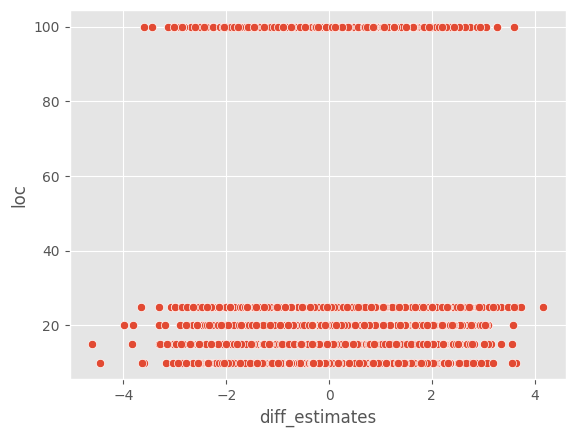

In [109]:
sns.scatterplot(
    data = estimate_df,
    x='diff_estimates',
    y='loc'
)

Text(0, 0.5, 'Difference in ATE\nobserved vs. prediction data')

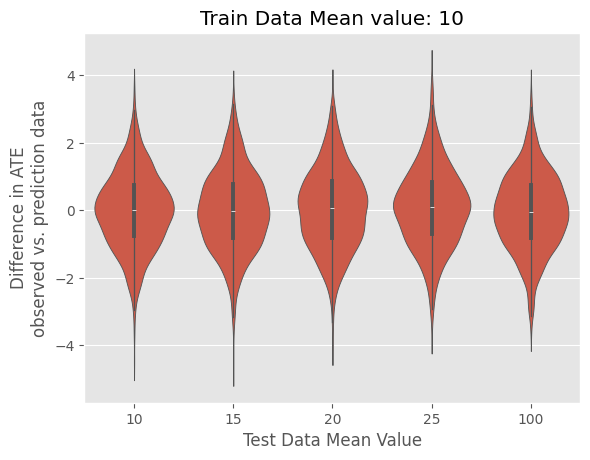

In [115]:
ax = sns.violinplot(
    data = estimate_df,
    x='loc',
    y='diff_estimates'
)
ax.set_title('Train Data Mean value: 10')
ax.set_xlabel('Test Data Mean Value')
ax.set_ylabel('Difference in ATE\nobserved vs. prediction data')


In [ ]:
aug_data.groupby('treatment')['unit_total'].mean()

treatment
0    1016.390105
1    1022.194690
Name: unit_total, dtype: float64

# Vary scale

In [116]:
testing_data_param_space = [
    {'loc':10, 'scale':1},
    {'loc':10, 'scale':5},
    {'loc':10, 'scale':10},
    {'loc':10, 'scale':15},
    {'loc':10, 'scale':50},
]
estimate_df_list = list()
for testing_data_param in testing_data_param_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6, dist_params = {'loc':10, 'scale':1})
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=2, n_surrogates=6, dist_params=testing_data_param)
        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)
        

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

        observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
        simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
        full_estimate_df = (
            pd.merge(
                observed_estimate_df,
                simulated_estimate_df,
                left_index=True,
                right_index=True,
                suffixes=('_observed', '_simulated')
            )
            .assign(
                diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
            )
            .assign(**testing_data_param)
        )

    estimate_df_list.append(full_estimate_df)

In [117]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,loc,scale
0,6.468098,1.311626e-41,5.145991,2.521622e-178,1.322107,10,1
1,5.717895,4.190267e-34,6.320685,8.591759e-239,-0.602791,10,1
2,5.319893,3.392625e-30,6.660089,3.044510e-194,-1.340196,10,1
3,5.750752,1.051274e-34,5.392991,8.360700e-181,0.357761,10,1
4,5.782093,2.336319e-33,7.237637,1.623319e-243,-1.455544,10,1


<Axes: xlabel='diff_estimates', ylabel='loc'>

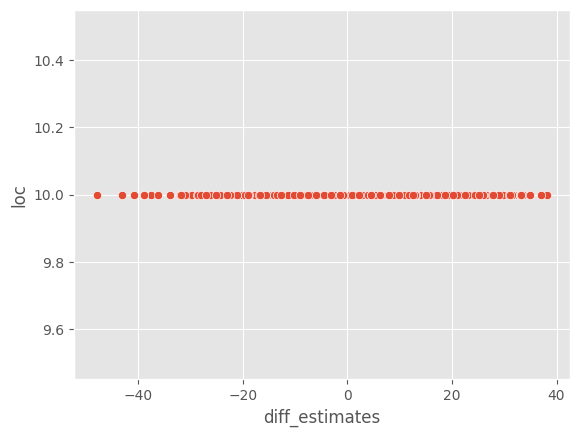

In [118]:
sns.scatterplot(
    data = estimate_df,
    x='diff_estimates',
    y='loc'
)

Text(0, 0.5, 'Difference in ATE\nobserved vs. prediction data')

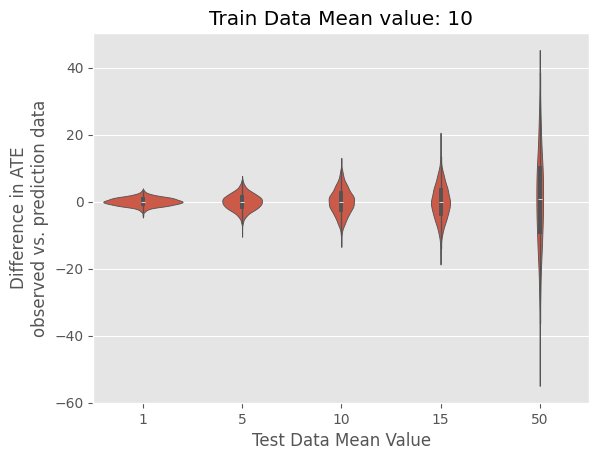

In [120]:
ax = sns.violinplot(
    data = estimate_df,
    x='scale',
    y='diff_estimates'
)
ax.set_title('Train Data Mean value: 10')
ax.set_xlabel('Test Data Mean Value')
ax.set_ylabel('Difference in ATE\nobserved vs. prediction data')


In [ ]:
aug_data.groupby('treatment')['unit_total'].mean()

treatment
0    1016.390105
1    1022.194690
Name: unit_total, dtype: float64